# Pull new images from xView into ShipRS

### Preprocessing: compare and contrast the xView and ShipRS Dataset

xView is a superset of the ShipRS dataset. Each image containing the fishing vessel instance came from xView but not all xView images containing the fishing vessel instance was actually incorporated into ShipRS. ShipRS currently has about 318 instances of the fishing vessel class in its training set. xView has 799 instances in its training set which means that not all the xView images were imported. Let's find out which xView images have not yet been included so that they may have the chance to be used in the training set for improved training and more robust data. Additionally, it's important to note that (1) validation labels were not provided in the xView dataset limiting the number of availble images, and (2) there's a total of 96 images and 800+ instances of fishing vessel class in train, test, trainval, val ShipRS image sets that must be accounted for in order to eliminate duplicate data

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import patches
from PIL import Image
import json
import pandas as pd
from pathlib import Path

Process each entry in ShipRS's fishing_vessel_images.txt

In [2]:
# Extract each image's "prefix"
# For example,  18__2164_920.bmp --> 18
#               1459__2760_920.bmp --> 1459 
shipRSPrefixes = set()
shipRSImages = {} # Key = image prefix | Value = a list of image paths containing this prefix

with open("fishing_vessel_shiprs.txt", "r") as f:
    lines = f.readlines()

for line in lines:
    # Extracts the sequence of numbers that come before the first "__"
    prefix = line.split("__")[0]
    
    # Keep track of the unique prefixes
    shipRSPrefixes.add(prefix)

    # Keep track of the images associated with each prefix
    if prefix not in shipRSImages:
        # First time encountering prefix
        shipRSImages[prefix] = [line[:-1]] # Remove the trailing new line character
    else:
        shipRSImages[prefix].append(line[:-1])
    
print(shipRSPrefixes)
print(shipRSImages)

{'1465', '1311', '1848', '1459', '1441', '1442', '1158', '1821', '1208', '1397', '2505', '1858', '2010', '2293', '1454', '1920', '1280', '1378', '2278', '1443', '1855', '1149', '126', '1351', '1918', '2562', '2555', '144', '1856', '1926', '1357', '1212', '2270', '2560', '2564', '2460', '1930', '1931', '18', '1829', '1820', '1217', '2268', '1447', '513', '2574', '1472', '1907', '1438', '1418', '1374', '2545', '1456', '1416', '1450', '107'}
{'1821': ['1821__2012_1840.bmp', '1821__1840_1840.bmp'], '2562': ['2562__1840_1840.bmp', '2562__0_1840.bmp', '2562__3207_2345.bmp', '2562__0_2345.bmp', '2562__2760_2345.bmp'], '2545': ['2545__3205_920.bmp', '2545__1840_0.bmp', '2545__1840_920.bmp', '2545__920_0.bmp', '2545__920_920.bmp', '2545__2760_920.bmp'], '1149': ['1149__1840_0.bmp', '1149__1840_1797.bmp'], '2574': ['2574__2760_0.bmp'], '107': ['107__1840_0.bmp'], '126': ['126__1840_0.bmp'], '2560': ['2560__0_920.bmp', '2560__920_1840.bmp', '2560__920_920.bmp', '2560__0_1840.bmp'], '1907': ['1907

Process each entry in xView's fishing_vessel_images.txt

In [3]:
xViewPrefixes = set()

with open("fishing_vessel_xview.txt", "r") as f:
    lines = f.readlines()

for line in lines:
    # Remove extension (.tif) in order to correctly extract the prefix
    xViewPrefixes.add(line[:-5])

print(xViewPrefixes)

{'1442', '2505', '1454', '1378', '1149', '126', '1918', '2555', '1926', '1357', '2560', '1930', '1931', '1940', '2571', '107', '1465', '2599', '1848', '1633', '1630', '1208', '1858', '2128', '2278', '1351', '2562', '31', '1212', '2270', '2564', '2268', '1906', '513', '1374', '1456', '1284', '1459', '1441', '1397', '1656', '2293', '2009', '1443', '1654', '1919', '1856', '2207', '2279', '1829', '1820', '2547', '128', '1472', '2574', '1907', '1418', '1438', '1416', '2008', '1450', '1311', '1824', '927', '1158', '1821', '2010', '1920', '1280', '1938', '1855', '144', '509', '1849', '2460', '1150', '18', '1831', '1217', '1447', '2545'}


Figure out which images are contained in xView but not in ShipRS

In [4]:
difference = xViewPrefixes.difference(shipRSPrefixes)
print(difference)

{'2599', '1824', '1633', '927', '1630', '1656', '2128', '2009', '1938', '1654', '1919', '31', '509', '1849', '2207', '2279', '1150', '1831', '1906', '2547', '128', '1940', '2571', '2008', '1284'}


Find out which images are contained in both xView and ShipRS

In [5]:
intersection = xViewPrefixes.intersection(shipRSPrefixes)
print(intersection)

{'1465', '1848', '1459', '1441', '1442', '1158', '1821', '1208', '1397', '2505', '1858', '2010', '2293', '1454', '1920', '1280', '1378', '2278', '1443', '1855', '1149', '126', '1351', '1918', '2562', '2555', '144', '1856', '1926', '1357', '1212', '2270', '2560', '2564', '2460', '1930', '1931', '18', '1829', '1820', '1217', '2268', '1447', '513', '2574', '1472', '1907', '1438', '1418', '1374', '2545', '1456', '1450', '1416', '1311', '107'}


For each image that's shared between xView and ShipRS, show them side-by-side so that they can be verified

In [6]:
def pad_images(img1, img2):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    max_height = max(h1, h2)
    max_width = w1 + w2  # Combined width

    # Create new images with padding
    img1_padded = np.zeros((max_height, max_width, 3), dtype=np.uint8)
    img2_padded = np.zeros((max_height, max_width, 3), dtype=np.uint8)

    img1_padded[:h1, :w1] = img1
    img2_padded[:h2, w1:w1+w2] = img2

    return img1_padded, img2_padded

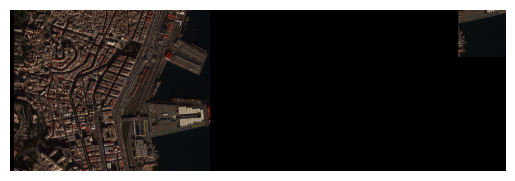

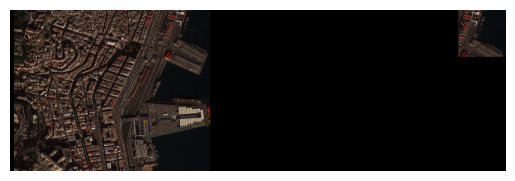

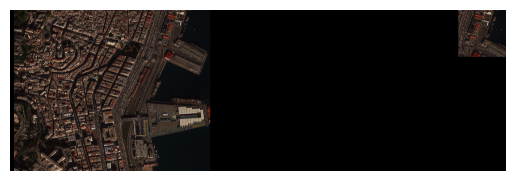

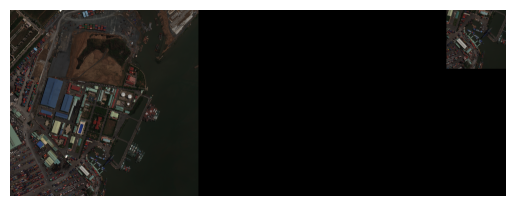

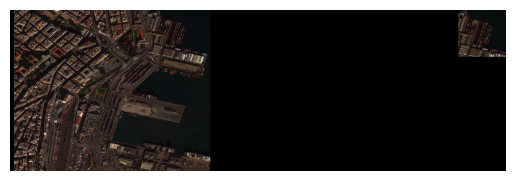

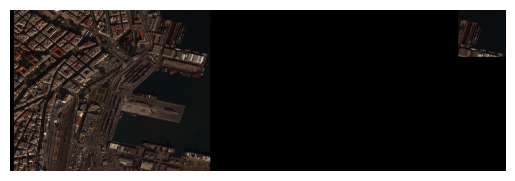

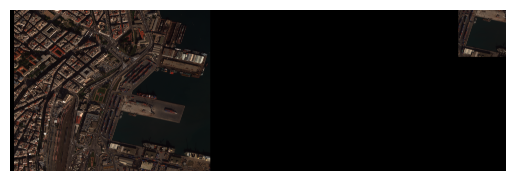

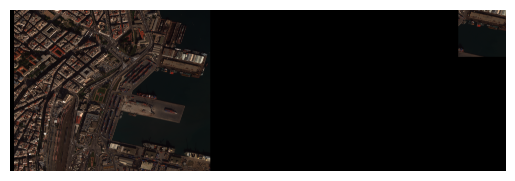

In [7]:
for prefix in list(intersection)[:3]:
    xView_image_path = os.path.join("xView", "train_images", f"{prefix}.tif")
    xView_image = cv2.imread(xView_image_path)

    for image in shipRSImages[prefix]:
        shipRS_image_path = os.path.join("ShipRSImageNet_V1", "VOC_Format", "JPEGImages", image)
        shipRS_image = cv2.imread(shipRS_image_path)

        xView_image_padded, shipRS_image_padded = pad_images(xView_image, shipRS_image)

        combined_image = np.hstack((xView_image_padded, shipRS_image_padded))

        plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

After close inspection, it can be confirmed that the ShipRS images pulled from the xView dataset are zoomed in portions of xView images

### Now: attempt to incorporate new images into ShipRS

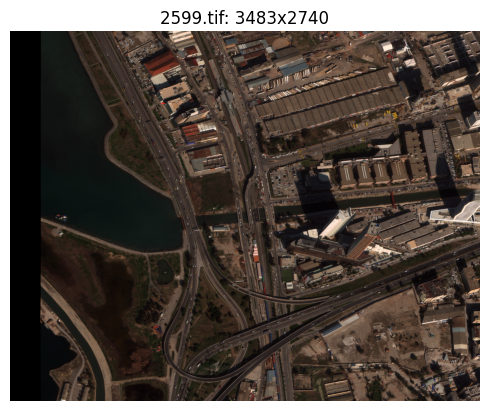

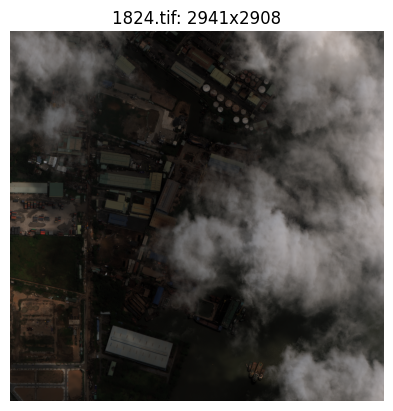

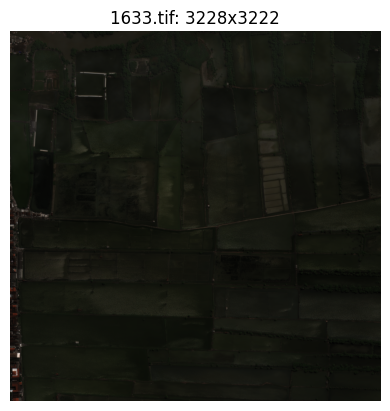

In [8]:
for image in list(difference)[:3]:
    path = os.path.join("xView", "train_images", f"{image}.tif")
    img = mpimg.imread(path)

    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    height,width = img.shape[:2]
    plt.title(f"{image}.tif: {width}x{height}")
    plt.show()
    plt.close()

The image sizes are huge which would be difficult for a computer vision model to process. According to ShipRS authors: "Since the image in xView is huge for training, we slice them into 930×930 pixels with 150 pixels overlap to produce 532 images and relabeled them with both horizontal bounding box and oriented bounding box." Note that dealing with large images often pose a problem for CV tasks because of the large amount of GPU memory required. Therefore, it's neccessary to normalize images in difference to the 930x930 sizing.

{
    "crs": {
        "properties": {"name": "urn:ogc:def:crs:OGC:1.3:CRS84"},
        "type": "name"
    },
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {
                "bounds_imcoords": "2712,1145,2746,1177",
                "edited_by": "wwoscarbecerril",
                "cat_id": "1040010028371A00",
                "type_id": 73,
                "ingest_time": "2017/07/24 12:49:09.118+00",
                "index_right": 2356,
                "image_id": "2355.tif",
                "point_geom": "0101000020E6100000616E4E6406A256C03BE6ADA0D6212D40",
                "feature_id": 374410,
                "grid_file": "Grid2.shp"
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [[[-90.53169885094464, 14.56603647302396], [-90.53169885094464, 14.56614473506768], [-90.53158140073565, 14.56614473506768], [-90.53158140073565, 14.56603647302396], [-90.53169885094464, 14.56603647302396]]]
            }
        }, 
        {
            "type": "Feature",
            "properties": {
                "bounds_imcoords": "2720,2233,2760,2288",
                "edited_by": "wwoscarbecerril",
                "cat_id": "1040010028371A00",
                "type_id": 73,
                "ingest_time": "2017/07/24 17:26:05.701+00",
                "index_right": 2356,
                "image_id": "2355.tif",
                "point_geom": "0101000020E6100000042D0CC705A256C0004F7071E71F2D40",
                "feature_id": 394393,
                "grid_file": "Grid2.shp"
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [[[-90.53167232380382, 14.562217332510999], [-90.53167232380382, 14.562407959236182], [-90.53153294103244, 14.562407959236182], [-90.53153294103244, 14.562217332510999], [-90.53167232380382, 14.562217332510999]]]
            }
        }, 
    ]
}

In [9]:
def load_annotations_as_df(annotations):
    with open(annotations, "r") as f:
        xview = json.load(f)

    features = xview["features"]

    filenames, databases, sources, resolutions, widths, heights, depths, xmins, ymins, xmaxs, ymaxs, classids = [], [], [], [], [], [], [], [], [], [], [], []

    for feature in features:
        properties = feature["properties"]
        filename = properties["image_id"]

        if filename[:-4] in difference:
            # Only add images of interest to the Dataframe
            bbox = properties["bounds_imcoords"]
            classid = properties["type_id"]

            bbox_coords = list(map(int, bbox.split(",")))
            xmin, ymin, xmax, ymax = bbox_coords[0], bbox_coords[1], bbox_coords[2], bbox_coords[3]

            filenames.append(filename)
            databases.append("WorldView 3")
            sources.append("xView")
            resolutions.append(0.3)
            widths.append(Image.open(os.path.join("xView", "train_images", filename)).width)
            heights.append(Image.open(os.path.join("xView", "train_images", filename)).height)
            depths.append(3)
            xmins.append(xmin)
            ymins.append(ymin)
            xmaxs.append(xmax)
            ymaxs.append(ymax)
            classids.append(classid)

    df = pd.DataFrame({
        "file_name": filenames,
        "database": databases,
        "source": sources,
        "resolution": resolutions,
        "width": widths,
        "height": heights,
        "depth": depths,
        "xmin": xmins,
        "ymin": ymins,
        "xmax": xmaxs,
        "ymax": ymaxs,
        "category_id": classids,
    })

    return df

anotations = os.path.join("xView", "xView_train.geojson")
df = load_annotations_as_df(anotations)
df.head()

file_name     database source  resolution  width  height  depth  xmin  ymin  \
0  2279.tif  WorldView 3  xView         0.3   3596    2725      3  3506   -80   
1  2279.tif  WorldView 3  xView         0.3   3596    2725      3  2654    33   
2  2279.tif  WorldView 3  xView         0.3   3596    2725      3  2637    32   
3  2279.tif  WorldView 3  xView         0.3   3596    2725      3  2700    27   
4  2279.tif  WorldView 3  xView         0.3   3596    2725      3  3179    35   

   xmax  ymax  category_id  
0  3610   338           89  
1  2665    46           18  
2  2644    45           18  
3  2714    49           73  
4  3190    80           24

In [10]:
fishing_vessel_df = df.query("category_id == 47")
fishing_vessel_df

file_name     database source  resolution  width  height  depth  xmin  \
159    2279.tif  WorldView 3  xView         0.3   3596    2725      3  2969   
346    2547.tif  WorldView 3  xView         0.3   4135    3275      3   313   
864    2128.tif  WorldView 3  xView         0.3   3085    2810      3  2832   
1898   2599.tif  WorldView 3  xView         0.3   3483    2740      3   246   
5222   2008.tif  WorldView 3  xView         0.3   4986    3181      3  4840   
...         ...          ...    ...         ...    ...     ...    ...   ...   
32173   128.tif  WorldView 3  xView         0.3   3093    2606      3  3007   
32174   128.tif  WorldView 3  xView         0.3   3093    2606      3  2994   
32175   128.tif  WorldView 3  xView         0.3   3093    2606      3  3023   
32176   128.tif  WorldView 3  xView         0.3   3093    2606      3  3043   
32190   128.tif  WorldView 3  xView         0.3   3093    2606      3   993   

       ymin  xmax  ymax  category_id  
159    1408  2997  1425           47  
346     704   387   915           47  
864      99  2846   128           47  
1898   2161   297  2209           47  
5222   1383  4957  1408           47  
...     ...   ...   ...          ...  
32173   382  3030   405           47  
32174   391  3013   413           47  
32175   379  3042   398           47  
32176   367  3061   385           47  
32190   772  1004   783           47  

[445 rows x 12 columns]

In [11]:
len(fishing_vessel_df.file_name.unique())

25

445 instances of fishing vessel class and 25 images!

In [12]:
def get_rectangle_params_from_pascal_bbox(bbox):
    xmin_top_left, ymin_top_left, xmax_bottom_right, ymax_bottom_right = bbox

    bottom_left = (xmin_top_left, ymax_bottom_right)
    width = xmax_bottom_right - xmin_top_left
    height = ymin_top_left - ymax_bottom_right

    return bottom_left, width, height

def draw_bboxes(
    plot_ax,
    bboxes,
    class_labels,
    get_rectangle_corners_fn=get_rectangle_params_from_pascal_bbox,
):
    for bbox, label in zip(bboxes, class_labels):
        bottom_left, width, height = get_rectangle_corners_fn(bbox)

        rect_1 = patches.Rectangle(
            bottom_left, width, height, linewidth=4, edgecolor="black", fill=False,
        )
        rect_2 = patches.Rectangle(
            bottom_left, width, height, linewidth=2, edgecolor="white", fill=False,
        )
        rx, ry = rect_1.get_xy()

        # Add the patch to the Axes
        plot_ax.add_patch(rect_1)
        plot_ax.add_patch(rect_2)
        plot_ax.annotate(label, (rx+width, ry+height), color='white', fontsize=10)

def show_image(image, bboxes=None, class_labels=None, draw_bboxes_fn=draw_bboxes):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)

    if bboxes:
        draw_bboxes_fn(ax, bboxes, class_labels)
        
    plt.show()


In [13]:
class DatasetAdaptor:
    def __init__(self, images_dir_path, annotations_dataframe):
        self.images_dir_path = Path(images_dir_path)
        self.annotations_df = annotations_dataframe
        self.file_name_to_idx = {
            image_id: idx
            for idx, image_id in enumerate(self.annotations_df.file_name.unique())
        }
        self.idx_to_file_name = {v: k for k, v, in self.file_name_to_idx.items()}

    def __len__(self) -> int:
        return len(self.file_name_to_idx)

    def __getitem__(self, index):
        file_name = self.idx_to_file_name[index]
        image = Image.open(self.images_dir_path / file_name)
        xyxy_bboxes = self.annotations_df.query("file_name == @file_name")[
            ["xmin", "ymin", "xmax", "ymax"]
        ].values
        class_labels = self.annotations_df.query("file_name == @file_name")[
            "category_id"
        ].values

        return np.array(image), xyxy_bboxes, class_labels, index

In [14]:
images_path = os.path.join("xView", "train_images")

In [15]:
ds = DatasetAdaptor(images_path, fishing_vessel_df)

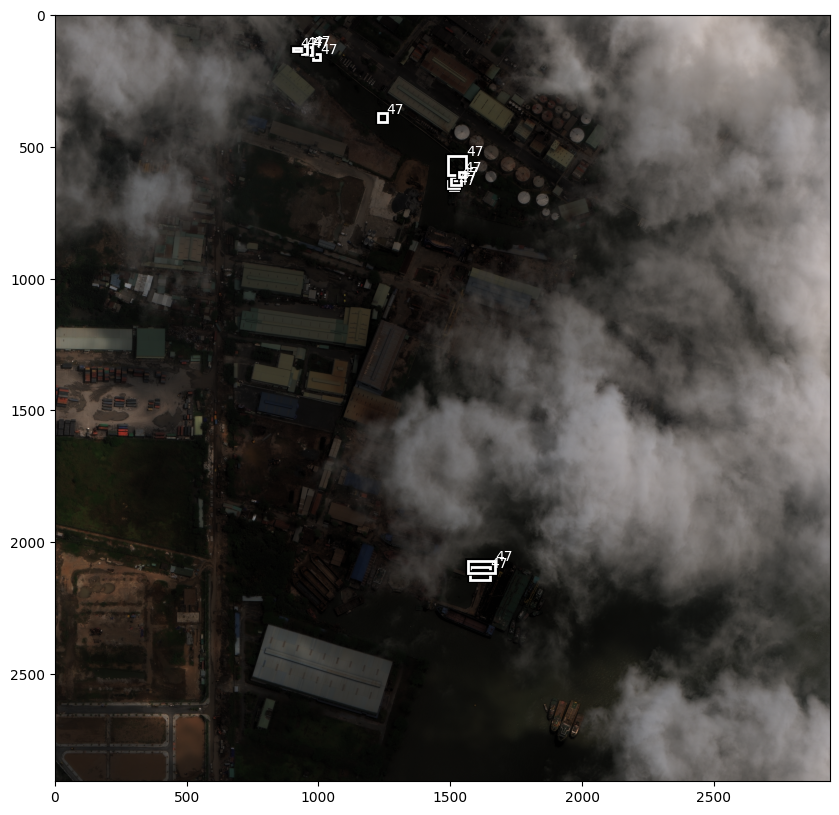

In [16]:
idx = 6
image, bboxes, class_labels, image_id = ds[idx]
show_image(image, bboxes.tolist(), class_labels.tolist())

In [17]:
ds.idx_to_file_name[6]

'1824.tif'

Currently we're able to pinpoint where the fishing vessels are in each image. As you can see from the sample image above, it's very difficult to see the object contained in the bbox. Opening up the image using `xdg-open` verifies that the annotations are correct. This highlights the fine-grained/ small object detection nature of this dataset and why cropping the image would comprimise the already limited detailing of the images. If you'd like to see all bboxes present in an image, run `ds = DatasetAdaptor(os.path.join("xView", "train_images"), df)` instead. However, since we're only interested in the fishing vessel class I didn't show that here.

In [18]:
def calculate_slice_bboxes(
    image_height: int,
    image_width: int,
    slice_height: int = 930,
    slice_width: int = 930,
    overlap_height: int = 150,
    overlap_width: int = 150,
):
    """
    Given the height and width of an image, calculates how to divide the image into
    overlapping slices according to the height and width provided. These slices are returned
    as bounding boxes in xyxy format.

    :param image_height: Height of the original image.
    :param image_width: Width of the original image.
    :param slice_height: Height of each slice
    :param slice_width: Width of each slice
    :param overlap_height_ratio: Fractional overlap in height of each slice (e.g. an overlap of 0.2 for a slice of size 100 yields an overlap of 20 pixels)
    :param overlap_width_ratio: Fractional overlap in width of each slice (e.g. an overlap of 0.2 for a slice of size 100 yields an overlap of 20 pixels)
    :return: a list of bounding boxes in xyxy format
    """

    slice_bboxes = []
    y_max = y_min = 0
    y_overlap = overlap_height # int(overlap_height_ratio * slice_height)
    x_overlap = overlap_width # int(overlap_width_ratio * slice_width)
    while y_max < image_height:
        x_min = x_max = 0
        y_max = y_min + slice_height
        while x_max < image_width:
            x_max = x_min + slice_width
            if y_max > image_height or x_max > image_width:
                xmax = min(image_width, x_max)
                ymax = min(image_height, y_max)
                xmin = max(0, xmax - slice_width)
                ymin = max(0, ymax - slice_height)
                slice_bboxes.append([xmin, ymin, xmax, ymax])
            else:
                slice_bboxes.append([x_min, y_min, x_max, y_max])
            x_min = x_max - x_overlap
        y_min = y_max - y_overlap
    return slice_bboxes

Let's test the slicing on a sample image at index 6

In [19]:
slices = calculate_slice_bboxes(image_height=image.shape[0], image_width=image.shape[1])

In [20]:
slices

[[0, 0, 930, 930],
 [780, 0, 1710, 930],
 [1560, 0, 2490, 930],
 [2011, 0, 2941, 930],
 [0, 780, 930, 1710],
 [780, 780, 1710, 1710],
 [1560, 780, 2490, 1710],
 [2011, 780, 2941, 1710],
 [0, 1560, 930, 2490],
 [780, 1560, 1710, 2490],
 [1560, 1560, 2490, 2490],
 [2011, 1560, 2941, 2490],
 [0, 1978, 930, 2908],
 [780, 1978, 1710, 2908],
 [1560, 1978, 2490, 2908],
 [2011, 1978, 2941, 2908]]

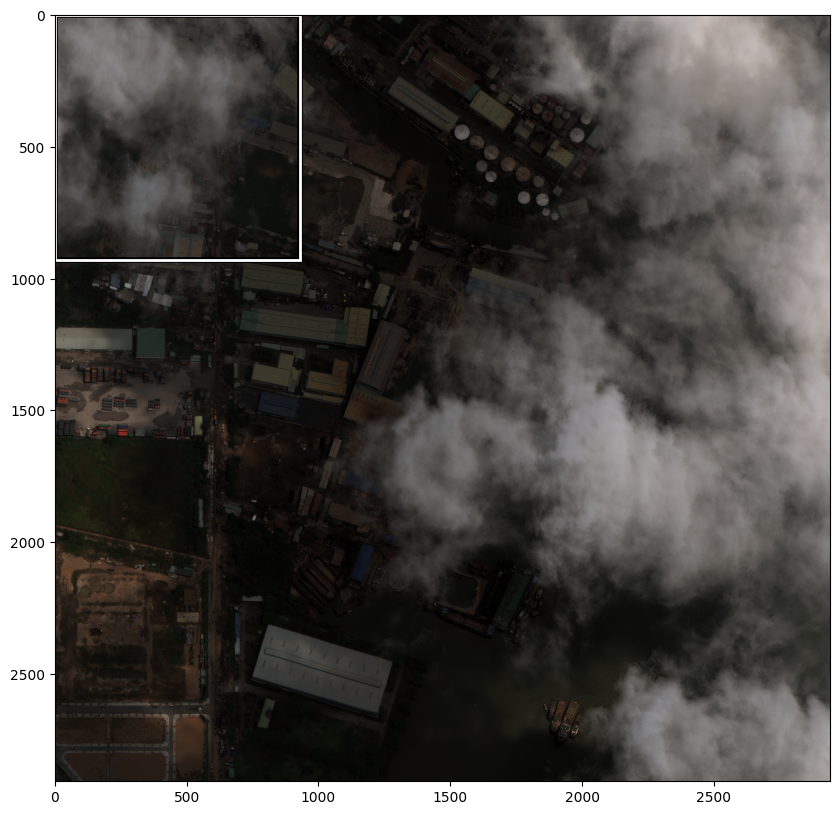

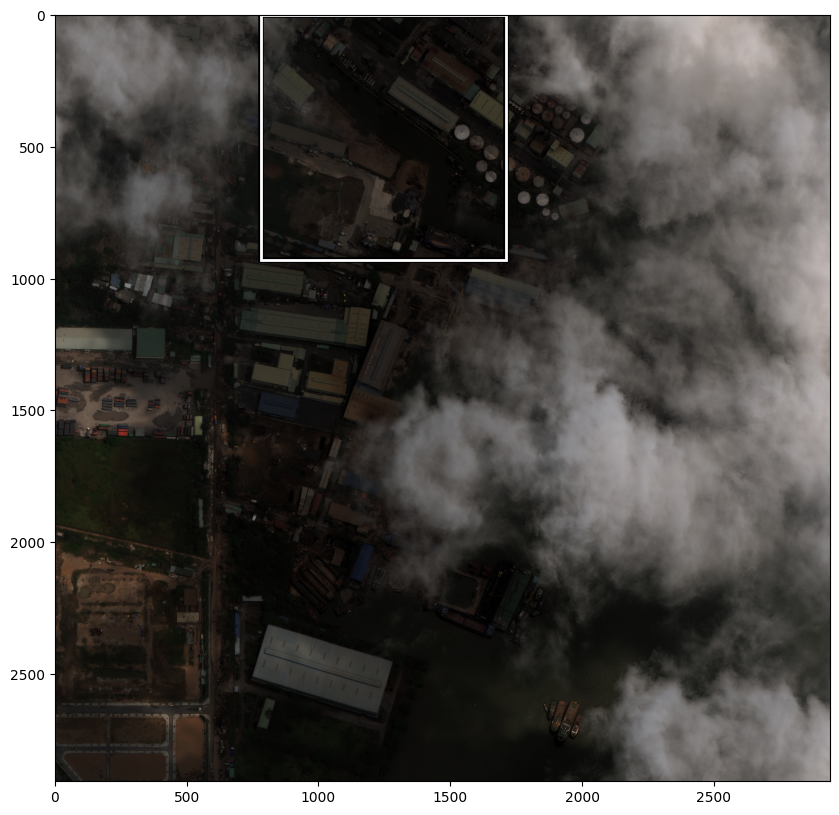

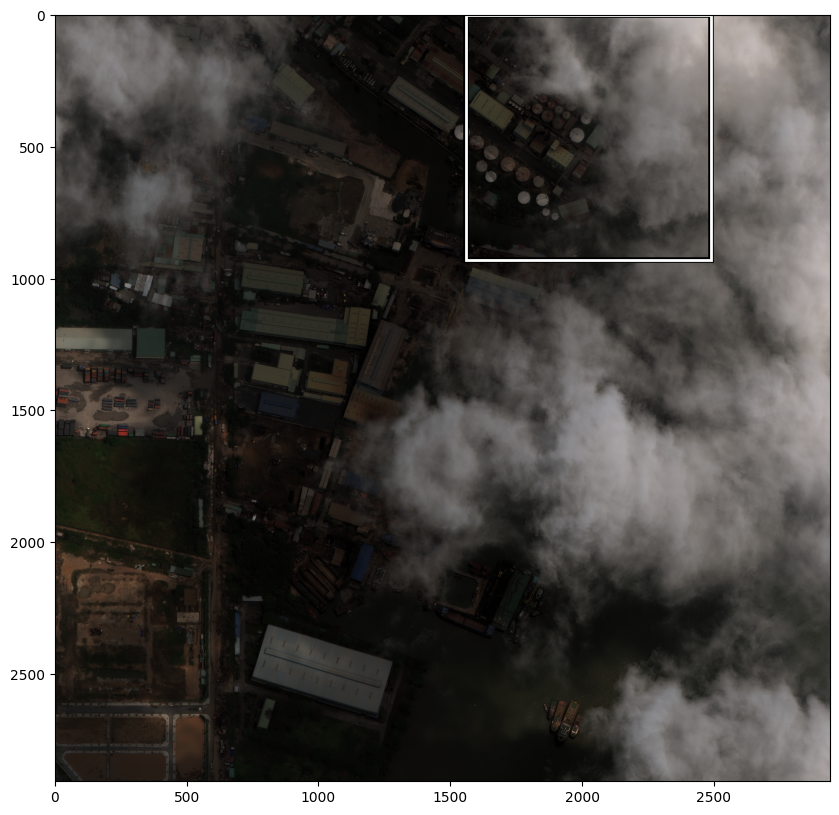

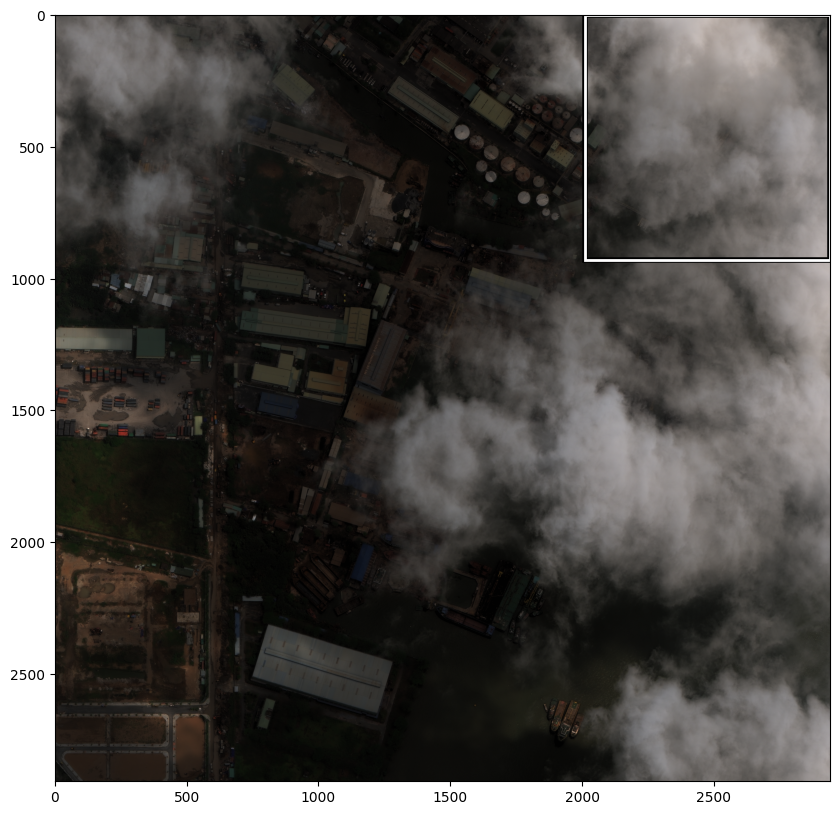

In [21]:
for slice_bbox in slices[:4]:
    show_image(image, [slice_bbox], [''])

Based on these first four slices of `image`, slicing seems to be working well!

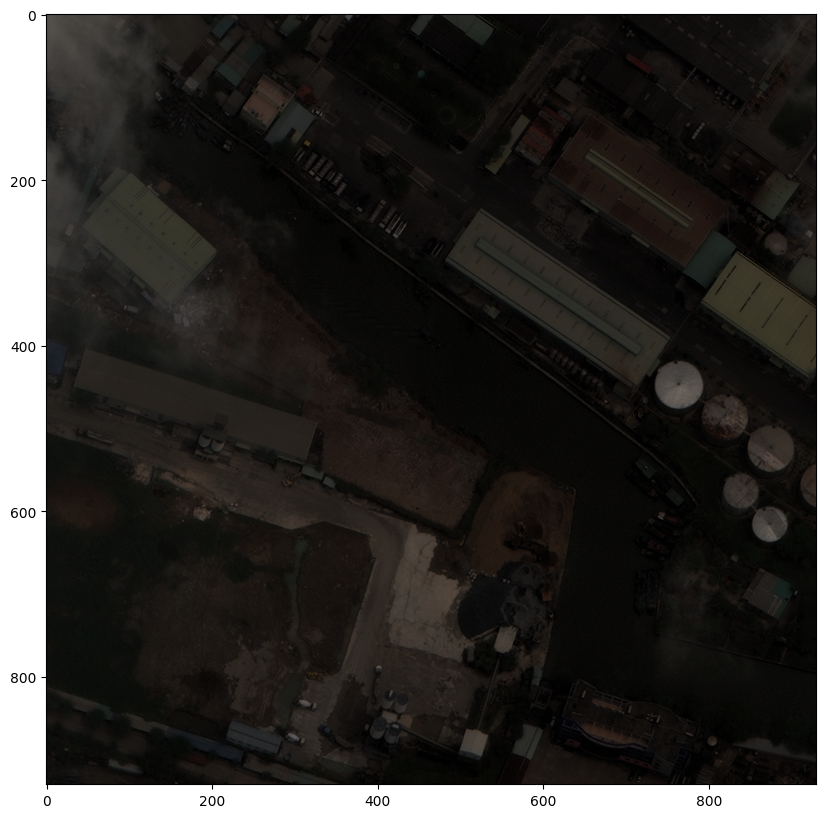

In [22]:
slice_index = 1
xmin, ymin, xmax, ymax = slices[slice_index]
show_image(image[ymin:ymax, xmin:xmax,])

In [23]:
import albumentations as A

In [24]:
crop_transform = A.Compose(
        [A.Crop(*slices[slice_index]),],
        bbox_params=A.BboxParams(format="pascal_voc",
                                 label_fields=['labels'],
                                 min_visibility=0.1,
                                 min_area=0.1),
    )

In [25]:
transformed = crop_transform(image=image, bboxes=bboxes, labels=class_labels)

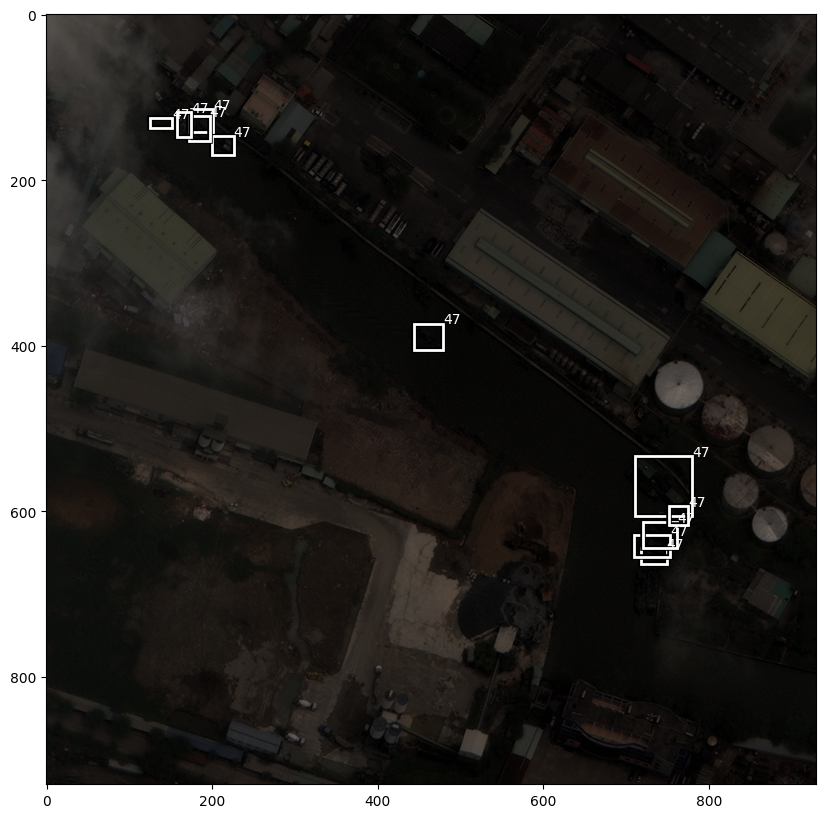

In [26]:
show_image(transformed['image'], transformed['bboxes'], transformed['labels'])

In [27]:
import os
from functools import partial
from PIL import Image

from multiprocessing import Pool

def get_image_sizes_df(images_path, file_names):
    pool = Pool(processes=len(os.sched_getaffinity(0)))
    image_sizes = pool.map(partial(get_image_size, images_path=images_path), file_names)
    sizes_df = pd.DataFrame(image_sizes)
    return sizes_df


def get_image_size(file_name, images_path):
    image = Image.open(images_path / file_name)
    w, h = image.size
    return {"file_name": file_name, "image_height": h, "image_width": w}

In [38]:
images_path = Path("xView/train_images")

In [46]:
def contains_object(
    annotations_df, image_slice_row, min_bbox_visibility=0.1, min_bbox_area=0.1
):
    xyxy_bboxes = annotations_df.query("file_name == @image_slice_row.file_name")[
        ["xmin", "ymin", "xmax", "ymax"]
    ].values

    # Correct for any out of range bbox annotations
    xyxy_bboxes[:, 0] = xyxy_bboxes[:, 0].clip(min=0) # xmin has lower bound of 0
    xyxy_bboxes[:, 1] = xyxy_bboxes[:, 1].clip(min=0) # ymin has lower bound of 0
    xyxy_bboxes[:, 2] = xyxy_bboxes[:, 2].clip(max=image_slice_row["image_width"]) # xmax has upper bound of image width
    xyxy_bboxes[:, 3] = xyxy_bboxes[:, 3].clip(max=image_slice_row["image_height"]) # ymax has upper bound of image height

    slice_bbox = image_slice_row[["xmin", "ymin", "xmax", "ymax"]].values
    
    transforms = A.Compose(
        [A.Crop(*slice_bbox)],
        bbox_params=A.BboxParams(
            format="pascal_voc",
            min_visibility=min_bbox_visibility,
            min_area=min_bbox_area,
            label_fields=["labels"],
        ),
    )
    transformed = transforms(
        # use dummy array to avoid loading image and labels
        image=np.ones((image_slice_row.image_height, image_slice_row.image_width, 3)),
        labels=np.ones(len(xyxy_bboxes)),
        bboxes=xyxy_bboxes,
    )

    transformed_boxes = transformed["bboxes"]

    return len(transformed_boxes) > 0

In [48]:
from functools import partial


def create_image_slices_df(
    images_path,
    fishing_vessel_df,
    slice_height: int = 930,
    slice_width: int = 930,
    overlap_height: int = 150,
    overlap_width: int = 150,
    min_bbox_area: float = 0.1,
    min_bbox_visibility: float = 0.1,
):
    # Return a dataframe associating each distinct image in fishing_vessel_df with its image size
    # | file_name	    image_height	image_width |
    # | 2279.tif	    2725	        3596        |
    sizes_df = get_image_sizes_df(images_path, fishing_vessel_df.file_name.unique())
    # Create a column called slices where for each row the slice bounding boxes will be returned
    # | file_name	image_height	image_width	    slices                        |
    # | 2279.tif	2725	        3596	        [[0, 0, 930, 930], [780,...   |
    sizes_df["slices"] = sizes_df.apply(
        lambda row: calculate_slice_bboxes(
            row.image_height,
            row.image_width,
            slice_height,
            slice_width,
            overlap_height,
            overlap_width,
        ),
        axis=1,
    )

    # Create a row for each slice and for each slice label slice[0] as xmin slice[1] as ymin...
    slices_row_df = (
        sizes_df[["file_name", "slices"]]
        .explode("slices")
        .rename(columns={"slices": "slice"})
    )
    slices_row_df = pd.DataFrame(
        slices_row_df.slice.tolist(),
        columns=["xmin", "ymin", "xmax", "ymax"],
        index=slices_row_df.file_name,
    ).reset_index()

    image_slices_df = pd.merge(
        slices_row_df,
        sizes_df[["file_name", "image_height", "image_width"]],
        how="inner",
        on="file_name",
    )
    
    # Create a column that specifies if a slice contains a fishing vessel 
    image_slices_df["contains_object"] = image_slices_df.apply(
        partial(
            contains_object,
            fishing_vessel_df,
            min_bbox_area=min_bbox_area,
            min_bbox_visibility=min_bbox_visibility,
        ),
        axis=1,
    )
    image_slices_df.reset_index(inplace=True)
    image_slices_df.rename(columns={"index": "slice_id"}, inplace=True)

    return image_slices_df

In [49]:
image_slices_df = create_image_slices_df(images_path, fishing_vessel_df)
image_slices_df.head()

slice_id file_name  xmin  ymin  xmax  ymax  image_height  image_width  \
0         0  2279.tif     0     0   930   930          2725         3596   
1         1  2279.tif   780     0  1710   930          2725         3596   
2         2  2279.tif  1560     0  2490   930          2725         3596   
3         3  2279.tif  2340     0  3270   930          2725         3596   
4         4  2279.tif  2666     0  3596   930          2725         3596   

   contains_object  
0            False  
1            False  
2            False  
3            False  
4            False

In [52]:
image_slices_df.contains_object.value_counts(normalize=True)

contains_object
False    0.873362
True     0.126638
Name: proportion, dtype: float64